In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import joblib

C:\Users\soham\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\soham\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\soham\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def load_data(file_path):
    """
    Load data from Excel file.

    Args:
    file_path (str): Path to the Excel file.

    Returns:
    DataFrame: Loaded data.
    """
    return pd.read_excel(file_path)

In [4]:
def preprocess_data(features):
    """
    Preprocess the data by filtering, removing columns, and one-hot encoding.

    Args:
    features (DataFrame): Input features DataFrame.

    Returns:
    DataFrame: Preprocessed features DataFrame.
    """
    features = features[features['MSE'] <= 600]
    features.columns = features.columns.str.replace('WholeDataSet_', '')

    columns_to_remove3 = [col for col in features.columns if 'Part3' in col]
    columns_to_remove2 = [col for col in features.columns if 'Part2' in col]
    columns_to_remove1 = [col for col in features.columns if 'Part1' in col]

    features = features.drop(columns=columns_to_remove1 + columns_to_remove2 + columns_to_remove3)

    features = features[(features['Tot_IQR'] != 0) & (features['Tot_Std Dev'] != 0)]
    columns_to_remove = ['Tot_IQR', 'Tot_Std Dev', 'Country_Code', 'Value_Count']
    features = features.drop(columns=columns_to_remove)

    features = pd.get_dummies(features)

    return features

In [5]:
def train_random_forest(train_features, train_labels):
    """
    Train Random Forest model.

    Args:
    train_features (array-like): Features for training.
    train_labels (array-like): Labels for training.

    Returns:
    RandomForestRegressor: Trained Random Forest model.
    """
    rf = RandomForestRegressor(n_estimators=1500, random_state=42)
    rf.fit(train_features, train_labels)
    return rf

In [6]:
def evaluate_model(predictions, test_labels):
    """
    Evaluate the model using various error metrics.

    Args:
    predictions (array-like): Predicted values.
    test_labels (array-like): Actual values.

    Returns:
    float: Mean Absolute Error.
    float: Mean Absolute Percentage Error.
    float: R-squared value.
    """
    mae = mean_absolute_error(test_labels, predictions)
    mape = mean_absolute_percentage_error(test_labels, predictions)
    r_squared = r2_score(test_labels, predictions)
    return mae, mape, r_squared

In [7]:
def plot_actual_vs_predicted(test_labels, predictions):
    """
    Plot actual vs predicted values.

    Args:
    test_labels (array-like): Actual values.
    predictions (array-like): Predicted values.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(test_labels, predictions)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    plt.show()

In [8]:
def plot_feature_importance(rf, feature_list):
    """
    Plot feature importances.

    Args:
    rf (RandomForestRegressor): Trained Random Forest model.
    feature_list (list): List of feature names.
    """
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature Importances")
    plt.bar(range(len(feature_list)), importances[indices], align="center")
    plt.xticks(range(len(feature_list)), [feature_list[i] for i in indices], rotation=90, fontsize=12)
    plt.xlim([-1, len(feature_list)])
    plt.tight_layout()
    plt.savefig('feature_importance_plot.png')
    plt.show()

Mean Absolute Error: 19.29
Mean Absolute Percentage Error: 0.4
R-squared: 0.84


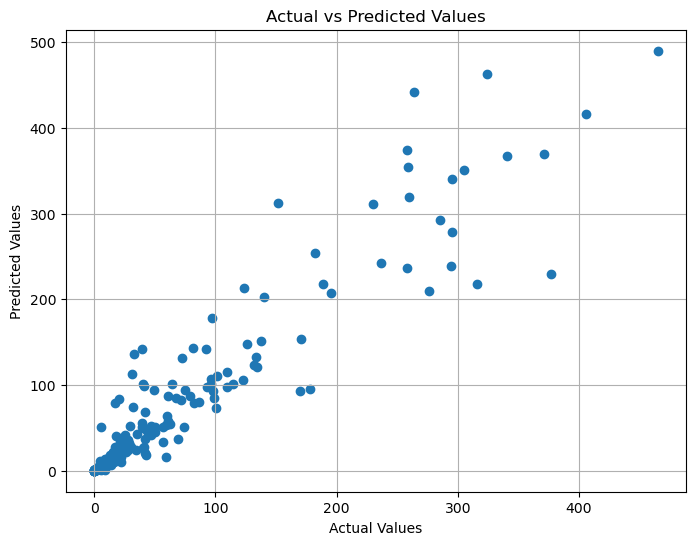

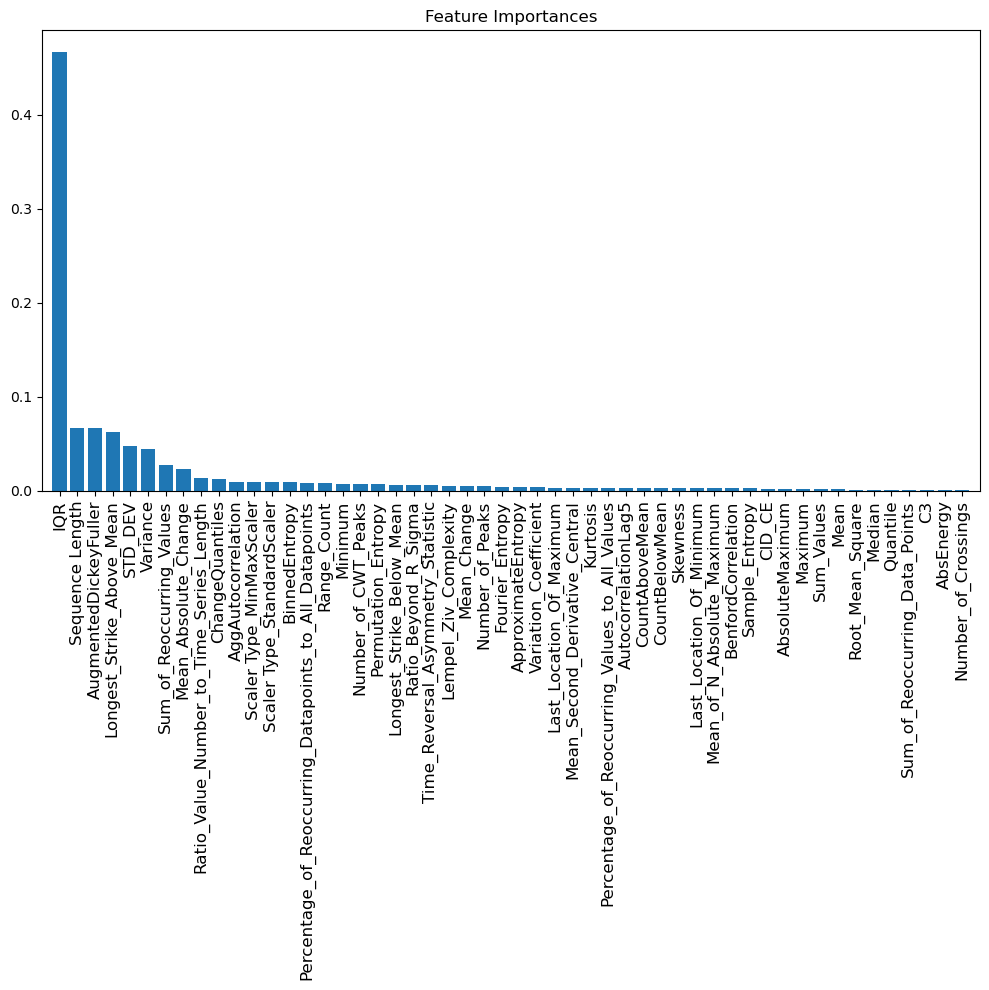

[ 1 49  6 20  0 47 44 24 39 11  4 50 51  9 33 37 29 31 35 21 38 46 19 25
 32]
Mean Absolute Error (Top 15 Features): 19.15
Mean Absolute Percentage Error (Top 15 Features): 0.39
R-squared (Top 15 Features): 0.84


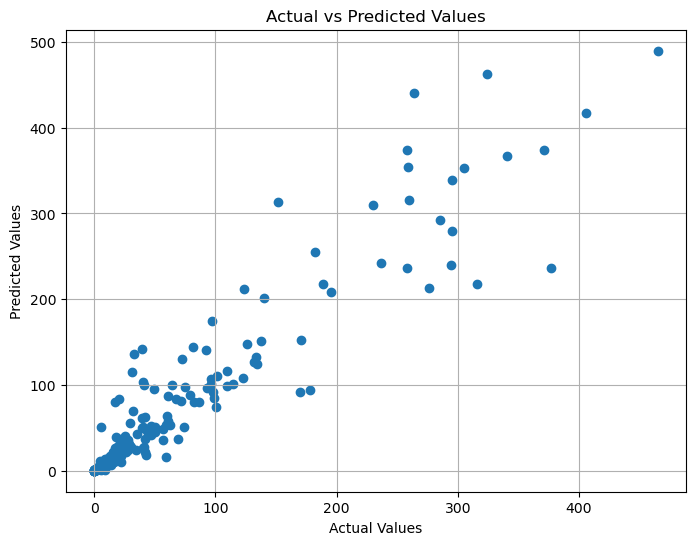

In [10]:
def main():
    # Load and preprocess data
    features = load_data(r'C:\Users\soham\Soham Master Thesis\Datasets\Generated_datasets_for_Regressor_Model\merged_data.xlsx')
    features = preprocess_data(features)

    # Prepare data for training
    labels = np.array(features['MSE'])
    features = features.drop('MSE', axis=1)
    feature_list = list(features.columns)
    features = np.array(features)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.20, random_state=42)

    # Train Random Forest model
    rf = train_random_forest(train_features, train_labels)
    joblib.dump(rf, 'random_forest_model.pkl')

    # Get predictions
    predictions = rf.predict(test_features)

    # Evaluate model
    mae, mape, r_squared = evaluate_model(predictions, test_labels)
    print('Mean Absolute Error:', round(mae, 2))
    print('Mean Absolute Percentage Error:', round(mape, 2))
    print('R-squared:', round(r_squared, 2))

    # Plot actual vs predicted values
    plot_actual_vs_predicted(test_labels, predictions)

    # Plot feature importance
    plot_feature_importance(rf, feature_list)
    # Select only the top 15 important features
    top_features_indices = rf.feature_importances_.argsort()[::-1][:25]
    print(top_features_indices)

    top_features = train_features[:, top_features_indices]

    # Retrain the model using only the top 15 important features
    rf_top_features = train_random_forest(top_features, train_labels)

    # Use the top features for test data as well
    test_top_features = test_features[:, top_features_indices]

    # Make predictions on the test data using the updated model
    predictions_top_features = rf_top_features.predict(test_top_features)

    # Evaluate the model with top features
    mae_top_features, mape_top_features, r_squared_top_features = evaluate_model(predictions_top_features, test_labels)
    print('Mean Absolute Error (Top 15 Features):', round(mae_top_features, 2))
    print('Mean Absolute Percentage Error (Top 15 Features):', round(mape_top_features, 2))
    print('R-squared (Top 15 Features):', round(r_squared_top_features, 2))

    # Plot actual vs predicted values with top features
    plot_actual_vs_predicted(test_labels, predictions_top_features)

if __name__ == "__main__":
    main()
